In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
import astropy.units as u
from astropy.modeling.models import custom_model
from scipy import interpolate
import keras
from scipy.optimize import Bounds
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')  # Location of Luci
import LUCI.LuciFit as lfit
import emcee
import corner


2022-09-07 07:32:41.971112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 07:32:41.971136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Read in Data

sigma_info = []
velocity_info = []
res_info = []
spectrum = fits.open('../Data/Reference-Spectrum-R5000.fits')
header = spectrum[0].header
spec = spectrum[1].data
channel = []
counts = []
for chan in spec:
    channel.append(chan[0])
    counts.append(chan[1])

axis = channel
sky = counts
velocity = header['VELOCITY']
sigma = header['BROADEN']
print(velocity, sigma)

0 10


In [3]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('../ML/Reference-Spectrum-R5000-SN3.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(np.real(chan[1]))
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

In [4]:
f = interpolate.interp1d(axis, sky, kind='slinear')
sky_corr = (f(wavenumbers_syn))
sky_corr_scale = np.max(sky_corr)
sky_corr = sky_corr/sky_corr_scale
print(sky_corr.shape)

(460,)


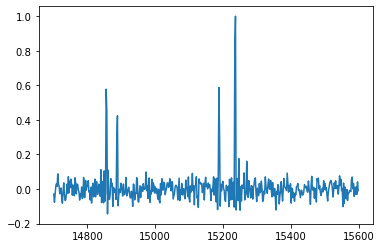

In [5]:
plt.plot(wavenumbers_syn, sky_corr)

In [6]:
fit = lfit.Fit(sky, axis, wavenumbers_syn, 'sincgauss', ['Halpha', 'NII6583', 'NII6548','SII6716', 'SII6731'], [1,1,1,1,1], [1,1,1,1,1],
                keras.models.load_model('../ML/R5000-PREDICTOR-I-SN3'),
                 bayes_bool=False, bayes_method='emcee')
fit_dict = fit.fit()
print(fit_dict['sigmas'])
print(fit_dict['fit_sol'])

2022-09-07 07:32:44.256640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-07 07:32:44.256672: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-07 07:32:44.256693: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-09-07 07:32:44.256902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[2.7268753972566326, 2.7268753972578264, 2.7268753972564883, 2.7268753972561406, 2.7268753972555624]
[1.00158531e+00 1.52365799e+04 3.26355151e-01 5.00440331e-01
 1.51888803e+04 3.25333465e-01 1.66808348e-01 1.52709481e+04
 3.27091291e-01 4.25486217e-01 1.48879734e+04 3.18888283e-01
 5.79309533e-01 1.48561662e+04 3.18207000e-01 1.28332525e-03]


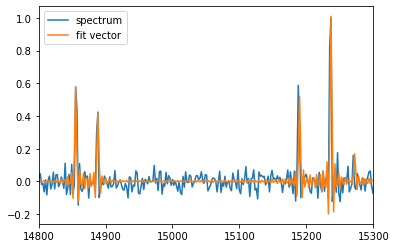

In [7]:
plt.plot(axis, sky, label='spectrum')
plt.plot(axis, fit_dict['fit_vector'], label='fit vector')
plt.xlim(14800, 15300)
plt.legend()

In [8]:
fit_dict['sigmas']

[2.7268753972566326,
 2.7268753972578264,
 2.7268753972564883,
 2.7268753972561406,
 2.7268753972555624]

In [9]:
fit_dict['amplitudes']

[1.001585314512719,
 0.500440331209256,
 0.16680834767738933,
 0.42548621678724885,
 0.5793095328845084]

In [10]:
fit_dict['velocities']

[16.109981251805994,
 16.109981242196785,
 16.109981240270226,
 16.109981242837296,
 16.10998123672965]